# Modeling Text Data

**Objective**

The task is to do text classification on a dataset of complaints about traffic conditions in the city of Boston. 
We breakdown the problem into two parts:

* First, we try to predict the type of complaint (“REQUESTTYPE”) from the complaint text.
* Second, try to come up with a better categorization of the data into semantic categories


**Data Description**

Live Vision Zero data from the "Safety Concerns" application.  This shapefile has all of the points that were entered. Use "REQUESTID" field to join Entry shapefile with Comment table. This data represents the points on the map.




You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

In [4]:
from csv import DictReader
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, SelectPercentile
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, adjusted_rand_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import string
import operator, functools
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import re
from scipy import sparse
import itertools
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd
from collections import Counter
import spacy
import warnings
warnings.filterwarnings('ignore')
sns.set(style="white")
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

# Task1 - Data Cleaning 

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

### a) Load the data

In [7]:
# Load data
data_df = pd.read_csv("Vision_Zero_Entry.csv")
data_df.head()

X          Y  OBJECTID  GLOBALID  REQUESTID  \
0 -71.059449  42.359295     13607       NaN    13607.0   
1 -71.072221  42.332621     13608       NaN    13608.0   
2 -71.093018  42.349864     13609       NaN    13609.0   
3 -71.091526  42.349158     13610       NaN    13610.0   
4 -71.067408  42.352338     13611       NaN    13611.0   

                                       REQUESTTYPE               REQUESTDATE  \
0           it's too far / too many lanes to cross  2016-01-15T21:21:43.000Z   
1           it's too far / too many lanes to cross  2016-01-15T21:34:49.000Z   
2  bike facilities don't exist or need improvement  2016-01-15T21:46:24.000Z   
3  bike facilities don't exist or need improvement  2016-01-15T21:47:56.000Z   
4  bike facilities don't exist or need improvement  2016-01-15T21:49:22.000Z   

       STATUS  STREETSEGID                                           COMMENTS  \
0  Unassigned            0                                                NaN   
1  Unassigned            0                                                NaN   
2  Unassigned            0  I feel scared biking on the "green carpet" bik...   
3  Unassigned            0  While I love that the Comm Ave bike lane is to...   
4  Unassigned            0  Need a bike facility to connect Boylston St to...   

  USERTYPE  
0    walks  
1    walks  
2    bikes  
3    bikes  
4    bikes

### b) Visualize the class distribution

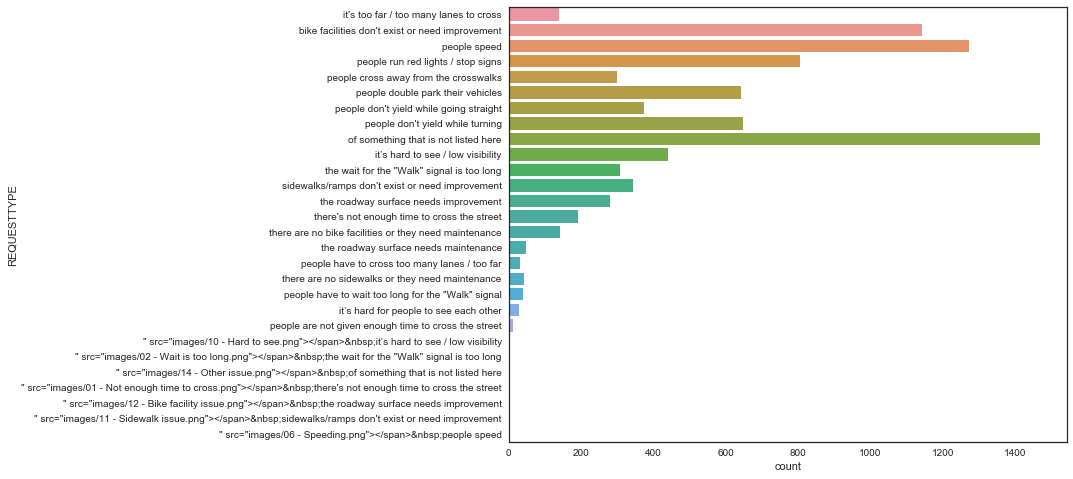

In [6]:
# Class distribution
plt.figure(figsize = (10,8))
_ = sns.countplot(y = "REQUESTTYPE", data = data_df)

### c) Clean up the target labels

** Removing unwanted symbols from the text data **

In [8]:
for i in range(len(data_df['REQUESTTYPE'])):
    
    m = re.search('&nbsp;(.+)', data_df['REQUESTTYPE'][i] )
    if m:
        data_df['REQUESTTYPE'][i] = m.group(1)

data_df['REQUESTTYPE'] = data_df.REQUESTTYPE.str.replace('\xe2\x80\x99', "'")

** Consolidating Similar Categories: Checking unique REQUESTTYPE for merging similar categories **

In [9]:
data_df['REQUESTTYPE'].unique()

array(["it's too far / too many lanes to cross",
       "bike facilities don't exist or need improvement", 'people speed',
       'people run red lights / stop signs',
       'people cross away from the crosswalks',
       'people double park their vehicles',
       "people don't yield while going straight",
       "people don't yield while turning",
       'of something that is not listed here',
       'it’s hard to see / low visibility',
       'the wait for the "Walk" signal is too long',
       "sidewalks/ramps don't exist or need improvement",
       'the roadway surface needs improvement',
       "there's not enough time to cross the street",
       'there are no bike facilities or they need maintenance',
       'the roadway surface needs maintenance',
       'people have to cross too many lanes / too far',
       'there are no sidewalks or they need maintenance',
       'people have to wait too long for the "Walk" signal',
       'it’s hard for people to see each other',
       

** Similar categories which we have to club into one: **

* the wait for the "Walk" signal is too long **&** people have to wait too long for the "Walk" signal
* people are not given enough time to cross the street **&** there's not enough time to cross the street
* there are no bike facilities or they need maintenance **&** bike facilities don't exist or need improvement
* 'there are no sidewalks or they need maintenance' **&** sidewalks/ramps don't exist or need improvement", 
* 'hard for people to see each other' **&** 'it's hard to see / low visibility'
* 'the roadway surface needs maintenance' **&** 'the roadway surface needs improvement',
* it's too far / too many lanes to cross **&** 'people have to cross too many lanes / too far

In [10]:
map_dict = {'people speed': 0, 
            'people run red lights / stop signs': 1,                                                
            'the wait for the "Walk" signal is too long': 2,
            'people have to wait too long for the "Walk" signal': 2,
            'people are not given enough time to cross the street': 3,
            "there's not enough time to cross the street": 3,
            'there are no bike facilities or they need maintenance': 4,
            "bike facilities don't exist or need improvement": 4,
            'there are no sidewalks or they need maintenance': 5,
            "sidewalks/ramps don't exist or need improvement": 5,
            'it’s hard for people to see each other': 6,
            'it’s hard to see / low visibility': 6,
            'the roadway surface needs maintenance': 7,
            'the roadway surface needs improvement': 7,
            "it's too far / too many lanes to cross": 8,
            'people have to cross too many lanes / too far': 8,
            'of something that is not listed here': 9,
            "people don't yield while going straight": 10,
            "people don't yield while turning": 11,
            'people double park their vehicles': 12,
            'people cross away from the crosswalks': 13}

In [11]:
final_yticks = []
for i in range(14):
    for k, v in map_dict.items():
        if v == i:
            final_yticks.append(k)
            break

In [12]:
data_df['REQUESTTYPE_CLASS'] = data_df.REQUESTTYPE.map(map_dict)    

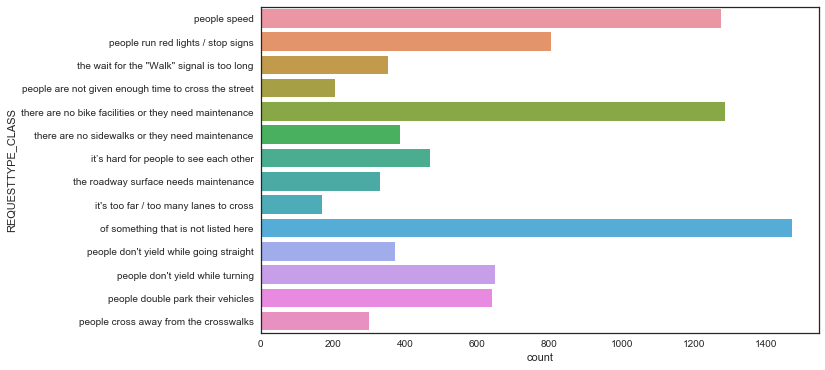

In [13]:
g = sns.countplot(y = "REQUESTTYPE_CLASS", data = data_df)
_ = g.set(yticklabels = final_yticks)

In [14]:
data_df.REQUESTTYPE_CLASS.isnull().sum()

0

### d) Remove duplicate rows for (comments, request_types) pairs and ignore null comments

In [15]:
data_df = data_df.loc[data_df.COMMENTS.notnull(), :]
data_df.reset_index(inplace = True)

** We also tried using the USERTYPE class to find the duplicate records, but it only resulted in 4 more records, therefore we are just find duplicated based on similar COMMENTS and REQUESTTYPE_CLASS. **

In [16]:
data_df.drop_duplicates(['COMMENTS', 'REQUESTTYPE_CLASS'], keep="first", inplace=True)

In [17]:
data_df.shape

(6618, 13)

In [18]:
data_df_copy = data_df.copy()

# Task2 - Model 1

We run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix.

### Check if the data, i.e., comments and the label data, i.e., REQUESTTYPE does not contain any NaNs?

In [21]:
data_df.COMMENTS.isnull().sum()

0

In [22]:
data_df.REQUESTTYPE_CLASS.isnull().sum()

0

### Create the training and testing data for our Baseline Models

In [23]:
X = data_df.COMMENTS
y = data_df.REQUESTTYPE_CLASS
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [24]:
def confusion_matrix_plt(y_test, y_pred, model_name):
    cf = confusion_matrix(y_test,y_pred)
    cmap=plt.cm.Greens
    plt.figure(figsize=(10,10))
    plt.imshow(cf, interpolation='nearest', cmap=cmap)
    plt.grid("off")
    plt.xticks(range(0,14))
    plt.yticks(range(0,14))
    plt.xlabel("Predicted Class", fontsize = 14)
    plt.ylabel("True Class",fontsize = 14)
    plt.title(model_name,fontsize = 16)
    thresh = cf.max() / 2.
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j],
                 horizontalalignment="center",
                 color="white" if cf[i, j] > thresh else "black")

In [25]:
def doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(pipeline, param_grid = parameters, cv=5, scoring="f1_macro", n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best cross validation score {}".format(grid.best_score_))
    print("Best parameters {}".format(grid.best_params_))
    prediction = grid.predict(X_test)
    print('macro f1: {}'.format(f1_score(y_test, prediction, average='macro')))
    return prediction, grid

### Baseline Model 1. Logistic Regression

** Using Countvectorizer (Bag of Words)**

In [26]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=42)),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5164683898836481
Best parameters {'clf__C': 1}
macro f1: 0.5489290597322225
CPU times: user 3.85 s, sys: 76 ms, total: 3.93 s
Wall time: 43.9 s


** Confusion Matrix **

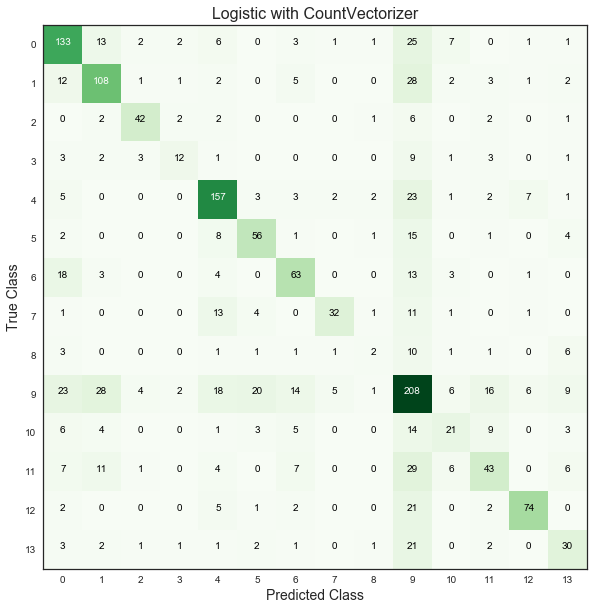

In [27]:
confusion_matrix_plt(y_test, prediction, "Logistic with CountVectorizer")

** Comments ** : Logistic Regressions gives f1 score of > 0.5, and is widely used for text classification, so we use it for our further analysis in Task 2 and we also show its confusion matrix.

### Baseline Model 2: SGDClassifier

** Using Countvectorizer (Bag of Words)**

In [29]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(random_state=42)),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.001, 0.01, 0.1),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (50, 80),
    #"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5118410344025471
Best parameters {'clf__alpha': 0.001, 'clf__n_iter': 50, 'clf__penalty': 'elasticnet'}
macro f1: 0.5386570064208461
CPU times: user 4.74 s, sys: 132 ms, total: 4.88 s
Wall time: 1min 4s


** Comments ** : SGDClassifier gives f1 score of > 0.5, but not higher f1 score as compared to Logistic Regression, therefore, we will not use it for Task 2 ahead.

### Baseline Model 3: MultinomialNB Classifier

In [30]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.1, 0.01, 0.001, 0.0001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    #"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5002542657359791
Best parameters {'clf__alpha': 0.1}
macro f1: 0.5092762389008606
CPU times: user 764 ms, sys: 68 ms, total: 832 ms
Wall time: 7 s


** Comments ** : MultinomialNB gives f1 score of > 0.5, but not higher f1 score as compared to Logistic Regression, therefore, we will not use it for Task 2 ahead.

### Baseline Model 4: Passive Aggressive Classifier (like Perceptron)

In [32]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', PassiveAggressiveClassifier(random_state=42)),
])

parameters = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    'clf__n_iter': (10, 50, 80),
    "clf__C": [0.001, 0.01, 0.1, 1],
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.518947361298525
Best parameters {'clf__C': 0.001, 'clf__n_iter': 80}
macro f1: 0.5621785184286506
CPU times: user 3.86 s, sys: 120 ms, total: 3.98 s
Wall time: 41.2 s


** Comments ** : PassiveAggressiveClassifier gives f1 score of > 0.5, but not higher f1 score as compared to Logistic Regression, therefore, we will not use it for Task 2 ahead. We will tune the Logistic Regression model in Task 2.

### We get best results with Logistic Regression and Count Vectorizer. F-1 score of 54.89. We created the confusion matrix for the LogisticRegression Classifier.

** Mistakes made by the Baseline Logistic Regression Model ** : Due to the highest occurrence of data values with the label of Class *of something that is not listed here* - it affects the final f1 score as this class contains a mixture of other possible class labels (which are not known or have not been listed). If we ignore the data values with class labels *of something that is not listed here*, we will see a increase in the final f1 score. Also, class with label *people are not given enough time to cross the street* and class with label *it's too far / too many lanes to cross* are classes with low support and a high number of misclassifications happen for these classes as their context match with a lot of other classes.

# Task3 - Model 2 

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

** In this section, we take the learnt best baseline model and improve on that model using further text features. The best model learnt from this section will be visualized in Task 4.**

### 1. Using Improved Tokenization, custom Tokenizer using NLTK and Spacy.

** Create custom tokenizer using nltk and spacy english models **

In [48]:
# import spacy
import nltk
import re

In [50]:

# load spacy's English language models
# en_nlp = spacy.load('en')
# instantiate NLTK's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the regexp above
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

def custom_tokenizer(document):
    doc_spacy = en_nlp(document, entity=False, parse=False)
    return [token.lemma_ for token in doc_spacy]

NameError: name 'spacy' is not defined

In [ ]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [ ]:


pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b", r"\b\w[\w’]+\b", r"\b\w[\w]+\b"],
    "vect__tokenizer" : [None, custom_tokenizer], # LemmaTokenizer was also tried but take times, so commented
    #"vect__max_df": (0.5, 0.75, 1.0),
    #"vect__min_df": (2, 3, 4, 5),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern and default tokenizer gives f1 score of 0.541 as compared to 0.53 from CountVectorizer normal parameters. The token pattern also includes all the single letter words. Also, using Spacy and NLTK tokenizer does not result in improvement as compared to default tokenizer used in CountVectorizer, therefore we use default tokenizer moving ahead. We also tried Lemmatokenizer which gave higher f1 score then custom_tokenizer, but it did not result in an improvement in the F1 score, though it did result in better tokens. 

### 2. Restricting the vocabulary

** a) Using stop words **

In [52]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__stop_words": ["english", None],
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5133982156959321
Best parameters {'clf__C': 1, 'vect__stop_words': 'english', 'vect__token_pattern': '\\b\\w+\\b'}
macro f1: 0.523587030879141
CPU times: user 2.45 s, sys: 100 ms, total: 2.55 s
Wall time: 39.1 s


** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern and default tokenizer gives f1 score of 0.541 as compared to 0.53 from CountVectorizer normal parameters. Also, ignoring stop words does not result in further improvement to f1 score and this will be ignored, mainly due to small size of the corpus.

** b) Using min_df values to ignore infrequent words **

In [53]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__min_df": [2, 3],
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5094899295064641
Best parameters {'clf__C': 1, 'vect__min_df': 3, 'vect__token_pattern': '\\b\\w+\\b'}
macro f1: 0.5552367757824658
CPU times: user 2.18 s, sys: 44 ms, total: 2.22 s
Wall time: 30 s


** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern and default tokenizer gives f1 score of 0.555 as compared to 0.548 from CountVectorizer normal parameters. 

** c) Using max_features to limit the total features in the model **

In [55]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    'vect__max_features': (2500, 5000),
    #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5104557848367217
Best parameters {'clf__C': 1, 'vect__max_features': 2500, 'vect__token_pattern': '\\b\\w+\\b'}
macro f1: 0.5532500473727922
CPU times: user 2.12 s, sys: 52 ms, total: 2.18 s
Wall time: 39.5 s


### 3. Beyond Single Words, using N-grams

In [ ]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__ngram_range": ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, _ = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern and default tokenizer and ngram range (1, 3), i.e., unigrams, bigrams and trigrams gives f1 score of 0.557 as compared to 0.53 from CountVectorizer normal parameters. 

### 4. Using TfIDF Scaling

In [24]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__ngram_range": ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
#     #'clf__alpha': (0.00001, 0.000001),
#     #'clf__penalty': ('l2', 'elasticnet'),
#     #'clf__n_iter': (10, 50, 80),
    "clf__C": [0.1, 1, 10]
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5322172058499759
Best parameters {'clf__C': 10, 'vect__ngram_range': (1, 2), 'vect__token_pattern': '\\b\\w+\\b'}
macro f1: 0.5523201568573863
CPU times: user 2.96 s, sys: 171 ms, total: 3.13 s
Wall time: 56.3 s


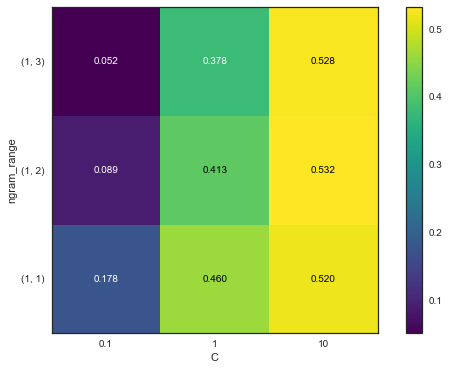

In [25]:
# Visualizing best cross validation scores
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heatmap
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=parameters['clf__C'],
    yticklabels=parameters['vect__ngram_range'])
plt.colorbar(heatmap)

** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern with default tokenizer and ngram range (1, 3), i.e., unigrams, bigrams and trigrams gives f1 score of 0.557 as compared to 0.53 from CountVectorizer normal parameters. Using the TfidfTransformer does not lead to an improvement in the f1-score from 0.557, but as the results are very close, it does not perform that bad, but we will ignore the tfidftransformer and try other features with the countvectorizer with its best obtained parameters.

### 5. Using Character N-grams (Respecting Word Boundaries)

In [68]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__ngram_range": ((2, 3), (2, 5)),  # unigrams or bigrams
    "vect__analyzer": ["char_wb"],
#     #'clf__alpha': (0.00001, 0.000001),
#     #'clf__penalty': ('l2', 'elasticnet'),
#     #'clf__n_iter': (10, 50, 80),
    "clf__C": [1, 10]
}

#prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.49220607516622494
Best parameters {'vect__token_pattern': '\\b\\w+\\b', 'clf__C': 1, 'vect__ngram_range': (2, 5), 'vect__analyzer': 'char_wb'}
macro f1: 0.4976463940564627
CPU times: user 24.6 s, sys: 363 ms, total: 25 s
Wall time: 4min 24s


** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern with default tokenizer and character ngram ranges gives f1 score of 0.497 as compared to 0.53 from CountVectorizer normal parameters. Using the character n-grams does not lead to an improvement in the f1-score, therefore we do not consider this feature set. The reason can be a reasonable size of documents(comments), whereas character n-grams work best for smaller strings.

### 6. Using Domain Specific Features, number of CAPS, number of punctuations and length of comment

In [75]:
vect = CountVectorizer(token_pattern=r"\b\w+\b")
new_data = vect.fit_transform(X)
new_data = new_data.toarray()

# Length of the comment
len_series = X.apply(len)
new_data = np.hstack((new_data, len_series.values.reshape(len_series.shape[0], 1)))

# Number of punctuations in the comment
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
punc_series = X.apply(lambda x: count(x, string.punctuation))
new_data = np.hstack((new_data, punc_series.values.reshape(punc_series.shape[0], 1)))

# Number of capital letters in the comment
caps_series = X.apply(lambda x: len(re.findall(r'[A-Z]',x)))
new_data = np.hstack((new_data, caps_series.values.reshape(caps_series.shape[0], 1)))

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_data, y, stratify=y, random_state=0)
new_X_train = sparse.csr_matrix(new_X_train)
new_X_test = sparse.csr_matrix(new_X_test)

In [79]:
%%time
pipeline = Pipeline([
#('tfidf', TfidfTransformer()),
('clf', LogisticRegression()),
])

parameters = {
    "clf__C": [0.1, 1, 10]
}
#prediction, grid = doGridSearch(pipeline, parameters, new_X_train, new_y_train, new_X_test, new_y_test)

Best cross validation score 0.5221099081164765
Best parameters {'clf__C': 1}
macro f1: 0.5375518533502903
CPU times: user 2.42 s, sys: 114 ms, total: 2.53 s
Wall time: 20 s


** Comments ** : Logistic Regressions using '\\b\\w+\\b' token pattern with default tokenizer and domain specific features, like the length of a comment, the number of punctuations in the comment and the number of capital letters in the comment, we do not see a significant improvement from the baseline logistic regression model. We do not visualize the results after using domain specific features in task 4.

# Task4 - Visualize Results

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

** Best Tuned Model : LemmaTokenizer used to obtain better important features **

In [26]:
%%time

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=LemmaTokenizer())), #taking LemmaTokenizer() as it gives better 
                                                           #tokens for visualization
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C = 1)),
])

parameters = {
    "vect__token_pattern" : [r"\b\w+\b"],
    "vect__ngram_range": ((1, 3),),  # unigrams or bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.5305589552703615
Best parameters {'vect__ngram_range': (1, 3), 'vect__token_pattern': '\\b\\w+\\b'}
macro f1: 0.5559658940807225
CPU times: user 14.6 s, sys: 341 ms, total: 15 s
Wall time: 1min 4s


### Classification Results

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction, target_names=final_yticks))

                                                       precision    recall  f1-score   support

                                         people speed       0.66      0.71      0.69       186
                   people run red lights / stop signs       0.62      0.69      0.65       162
           the wait for the "Walk" signal is too long       0.67      0.49      0.57        57
          there's not enough time to cross the street       0.92      0.36      0.52        33
there are no bike facilities or they need maintenance       0.65      0.73      0.69       204
      sidewalks/ramps don't exist or need improvement       0.69      0.52      0.59        85
               it’s hard for people to see each other       0.67      0.56      0.61       103
                the roadway surface needs improvement       0.82      0.53      0.65        62
               it's too far / too many lanes to cross       0.50      0.07      0.13        27
                 of something that is not listed 

** Comments: **

* Classes with lower support, i.e., less number of data points, generally have lower f1-score in our corpus and lead to a higher number of misclassifications. The class "it's too far / too many lanes to cross" has the worst recall of all the classes, which results in such a low f1-score for that class.
* Class with label "of something that is not listed here" has the highest support but also has poor recall score, leading to lower f1 scores for this class. As these are classes whose labels are not available, if we can improve this class labels, it will lead to improved f1-scores.
* Class with label "people are not given enough time to cross the street" also has lower support and along with it lower recall, resulting in comparably low f1-scores. 

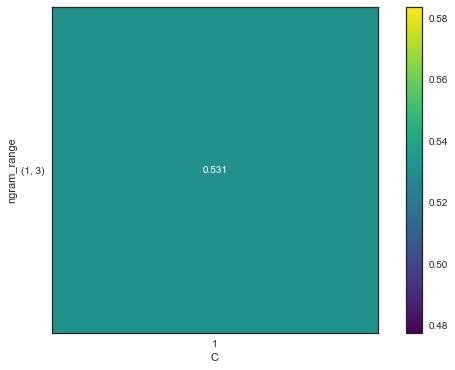

In [28]:
# Classifier Cross Validation Result for ngram_range(1, 3) and C == 1
scores = grid.cv_results_['mean_test_score'].reshape(-1, 1).T
# visualize heatmap
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=["1"],
    yticklabels=parameters['vect__ngram_range'])
plt.colorbar(heatmap)

### Confusion Matrix

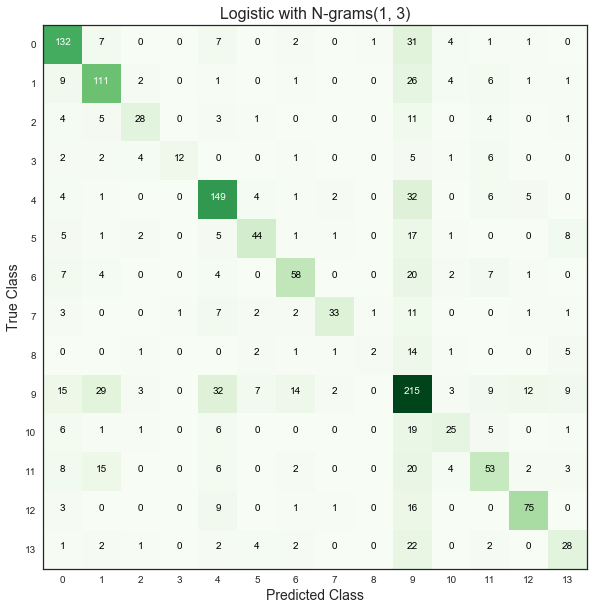

In [29]:
confusion_matrix_plt(y_test, prediction, "Logistic with N-grams(1, 3)")

### Plot Important Features

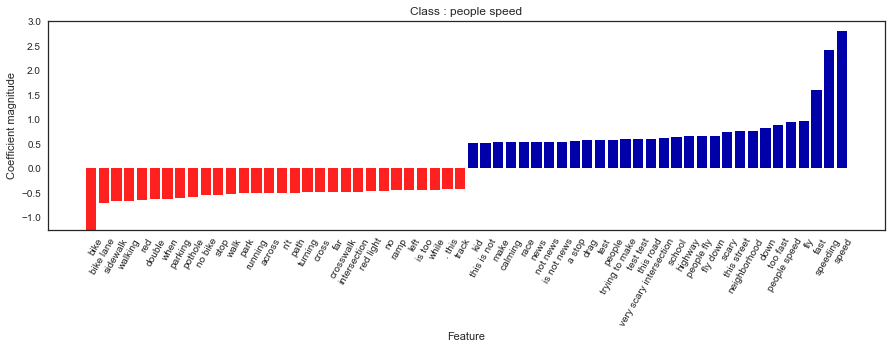

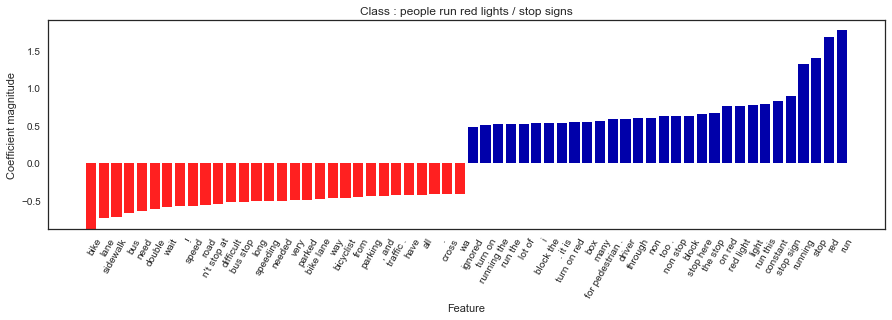

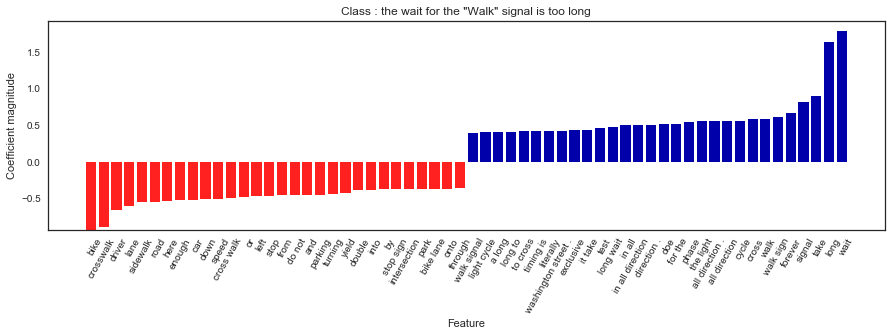

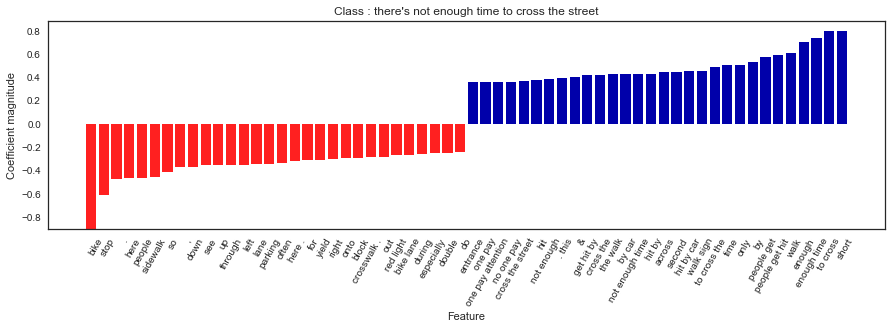

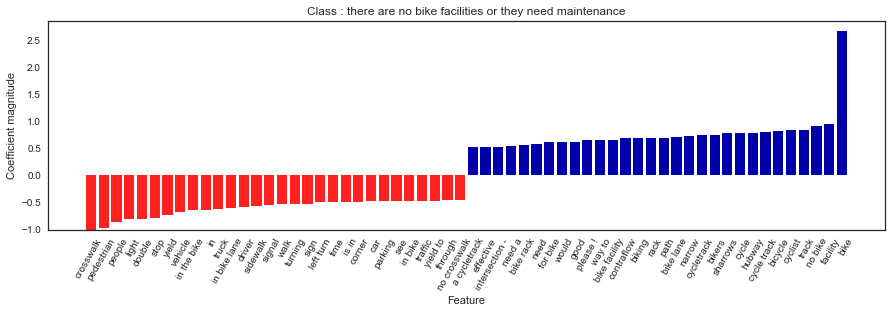

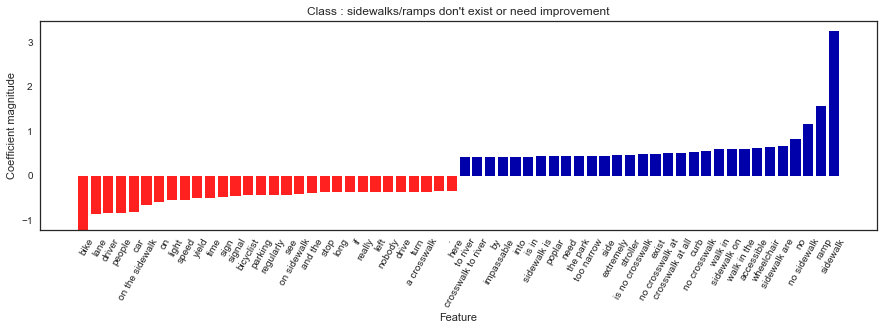

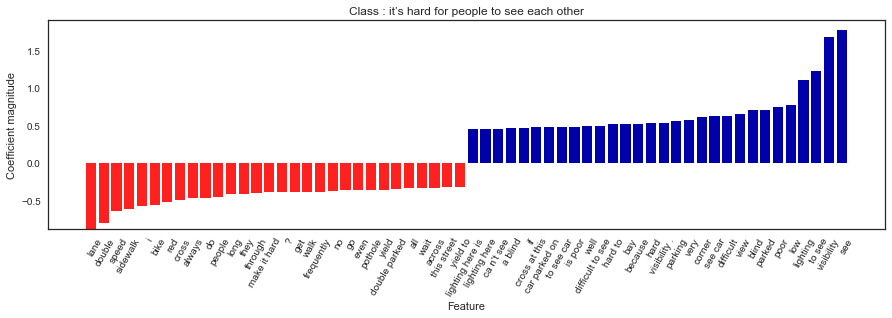

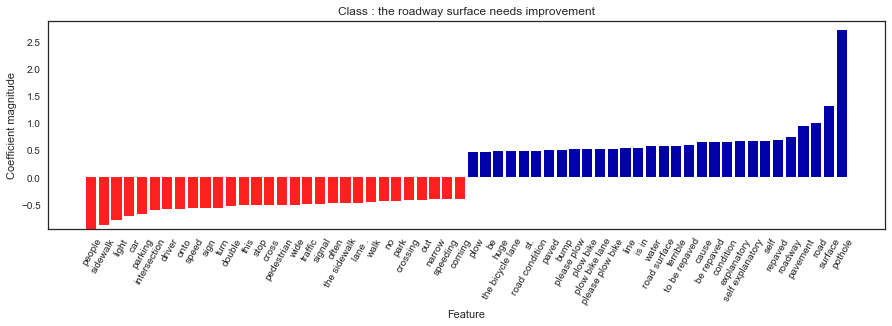

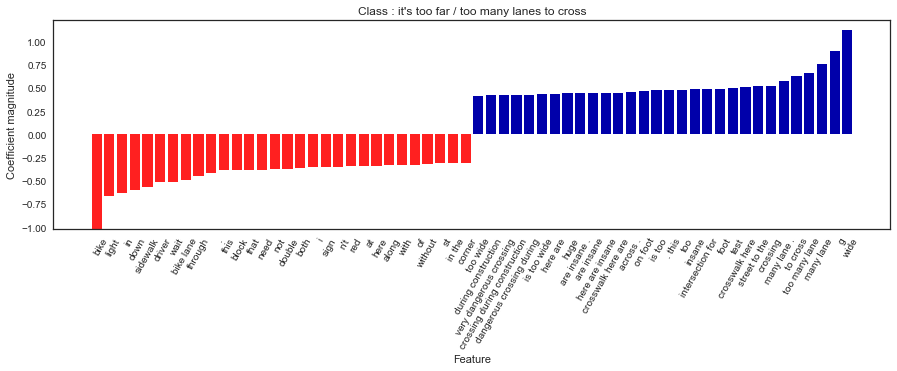

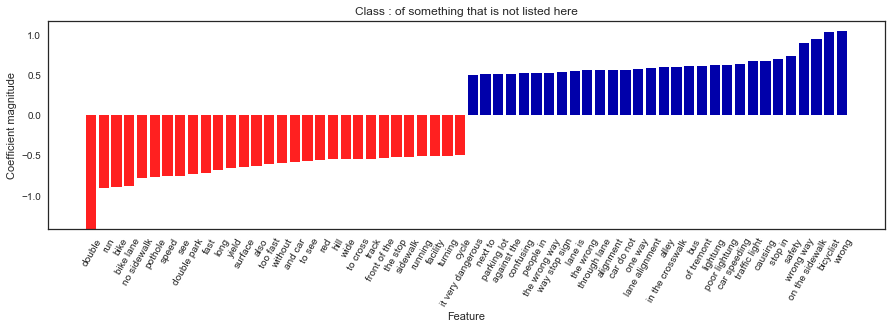

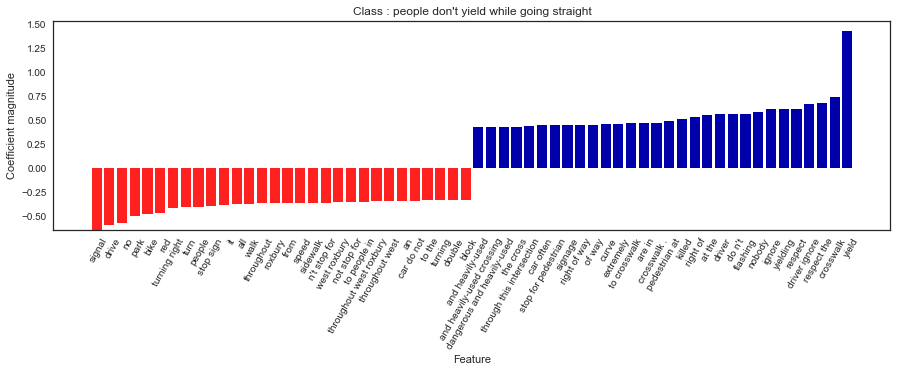

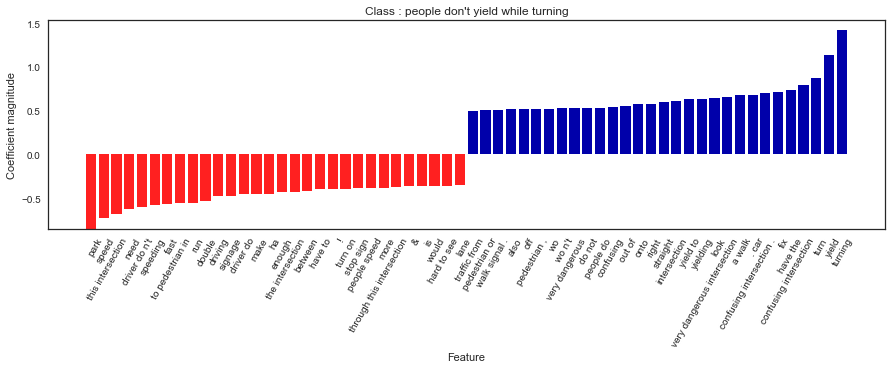

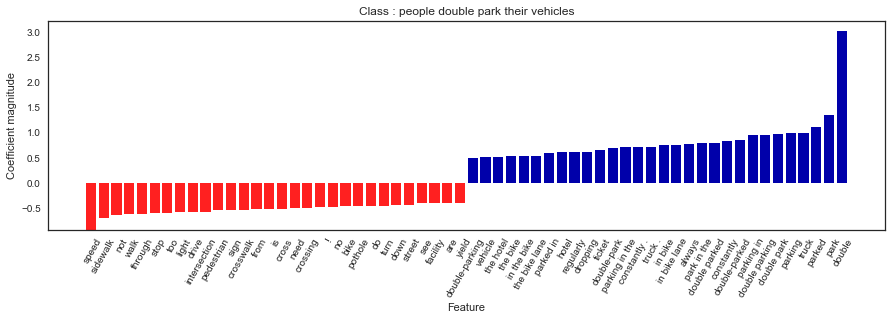

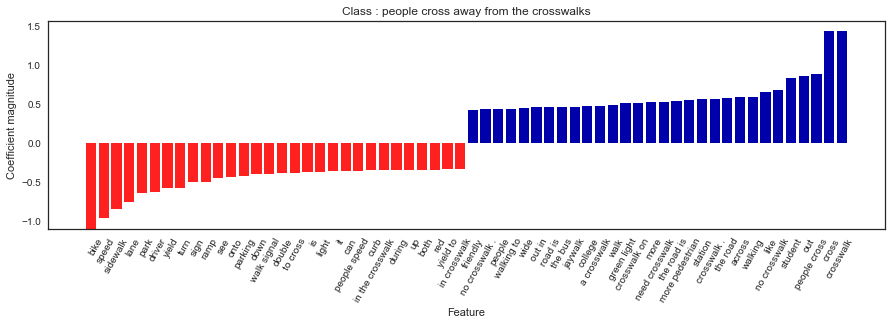

In [30]:
vectorizer = grid.best_estimator_.named_steps["vect"]
feature_names = np.array(vectorizer.get_feature_names())
important_feature_names = {}

for i in range(len(final_yticks)):
    
    inds = np.argsort(grid.best_estimator_.named_steps["clf"].coef_[i].ravel())
    low = inds[:15]
    high = inds[-15:]
    important = np.hstack([low, high])
    important_feature_names[i] = feature_names[important]
    
    plt.figure()
    _ = mglearn.tools.visualize_coefficients(
        grid.best_estimator_.named_steps["clf"].coef_[i],
        feature_names, n_top_features=30)
    plt.title("Class : {}".format(final_yticks[i]))

In [31]:
#important_feature_names

### Example Mistakes

** Five sample Prediction mistakes for each of the 14 classes have been shown in a table below **

In [32]:
mistake_text = []
observed_label = []
observed_text = []
predicted_label = []
predicted_text = []

for i in range(len(final_yticks)): # class loop
    count = 0
    for j in range(len(prediction)):
        if y_test.values[j] == i and prediction[j] != i:
            mistake_text.append(data_df.loc[y_test.index[j], "COMMENTS"])
            observed_label.append(y_test.values[j])
            observed_text.append(final_yticks[y_test.values[j]])
            predicted_label.append(prediction[j])
            predicted_text.append(final_yticks[prediction[j]])
            #print(data_df.loc[y_test.index[j], "COMMENTS"], y_test.values[j], prediction[j])
            count += 1
            if count == 5:
                break

In [33]:
example_mistake_df = pd.DataFrame({'comment_text':mistake_text, 'observed_label': observed_label, 
                                   'observed_text':observed_text, 'predicted_label':predicted_label,
                                   'predicted_text':predicted_text}, 
                                  columns=['comment_text', 'observed_label', 'observed_text', 'predicted_label', 'predicted_text'])
example_mistake_df.set_index("comment_text")


observed_label  \
comment_text                                                         
Eliminating two parking spaces on the south sid...               0   
Even during morning rush hour, there never seem...               0   
People run red light, speed, ignore crosswalk l...               0   
need a safer way to get across Lincoln Street f...               0   
There are increasing numbers of commercial vehi...               0   
Traffic flowing from Storrow Drive East onto Cl...               1   
People turning right onto Corey towards Centre ...               1   
People constantly run both sets of lights on Ar...               1   
The light was recently replaced, and they moved...               1   
People roll or don't stop at all coming down ar...               1   
The wait is long so few people wait the whole t...               2   
people try to walk during turning light                          2   
The intersection of the MBTA Charles St Station...               2   
Drivers always run the red light at this inters...               2   
The walk signal will say Do Not Cross for quite...               2   
There are times when traffic on Comm Ave is sto...               3   
Once the walking sign turns to the red hand the...               3   
And the cross signals need to be synced.  Peopl...               3   
The walk signal here is never sufficient to cro...               3   
Cars turn right on red here and it makes it dif...               3   
Hyde Park Ave from Metropolitan Ave north has f...               4   
Automobile traffic turns right from all three l...               4   
The pavement is awful, ppl park on the sidewalk...               4   
People don't take the turn wide enough and cut ...               4   
There isn't much space for bikes along this str...               4   
this part of providence hwy, it is really hard ...               5   
This is a treacherous intersection to try to ge...               5   
The radius of the curve from NB Centre promotes...               5   
People coming from the Yawkey station want to g...               5   
I've witnessed 2 car accidents due to people no...               5   
...                                                            ...   
The large bus lanes and unclear pedestrian cros...               8   
Comm. Ave. and many streets have different sign...               8   
The road is too wide, too many lanes, and cars ...               8   
Hard to get to stores on opposite sides of inte...               8   
There are too many ways to go: The immediate tu...               8   
I suggest no parking sign & curb paint @ kittre...               9   
There needs to be a speed hump to slow people. ...               9   
The direction of Shawmut changes every few bloc...               9   
Red light on Beacon is too long so people run l...               9   
The sidewalk parking occurs on the east side of...               9   
Just a crazy scene in this block for cars, peds...              10   
Level crossing for the bike path, inbound trave...              10   
There is often little to no oppprtunity for car...              10   
I can stand there for 5 minutes, or longer duri...              10   
This merge is awful. Cars pile up and it someti...              10   
Pedestrians get a walk light at the same time a...              11   
this intersection is terrible, no one ever yiel...              11   
People turn right on red when there are pedestr...              11   
There is no prohibition on right turns on red f...              11   
Adding a voice to the chorus who feel the separ...              11   
trucks regularly block the road in peak traffic...              12   
all along Boylston, not just here                               12   
Buses and livery vehicles waiting for guests at...              12   
18-wheelers park for days at a time on this str...              12   
The Tufts shuttle buses stop in the travel lane...            

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

### a) LDA (Latent Dirichlet Allocation)

In [20]:
# LDA 
vect = CountVectorizer(stop_words="english")
X_lda = vect.fit_transform(X)
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",
                                max_iter=25, random_state=0)
document_topics = lda.fit_transform(X_lda)

In [21]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 6304)


In [22]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [23]:
# print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
stop          bike          light         bike          st            
people        lane          turn          st            sidewalk      
street        road          red           lanes         speeding      
sign          dangerous     left          street        street        
cross         lanes         st            way           road          
way           speed         right         need          hills         
walk          traffic       cars          traffic       crosswalk     
speed         sidewalk      ave           ave           forest        
cars          needs         green         intersection  needs         
intersection  area          run           path          south         


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
park

** ARI Score **

In [24]:
ari = adjusted_rand_score(y.values, np.argsort(document_topics, axis = 1)[:,-1])
ari

0.07329255796937674

** Visualizing LDA **

In [25]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right", fontsize=20)

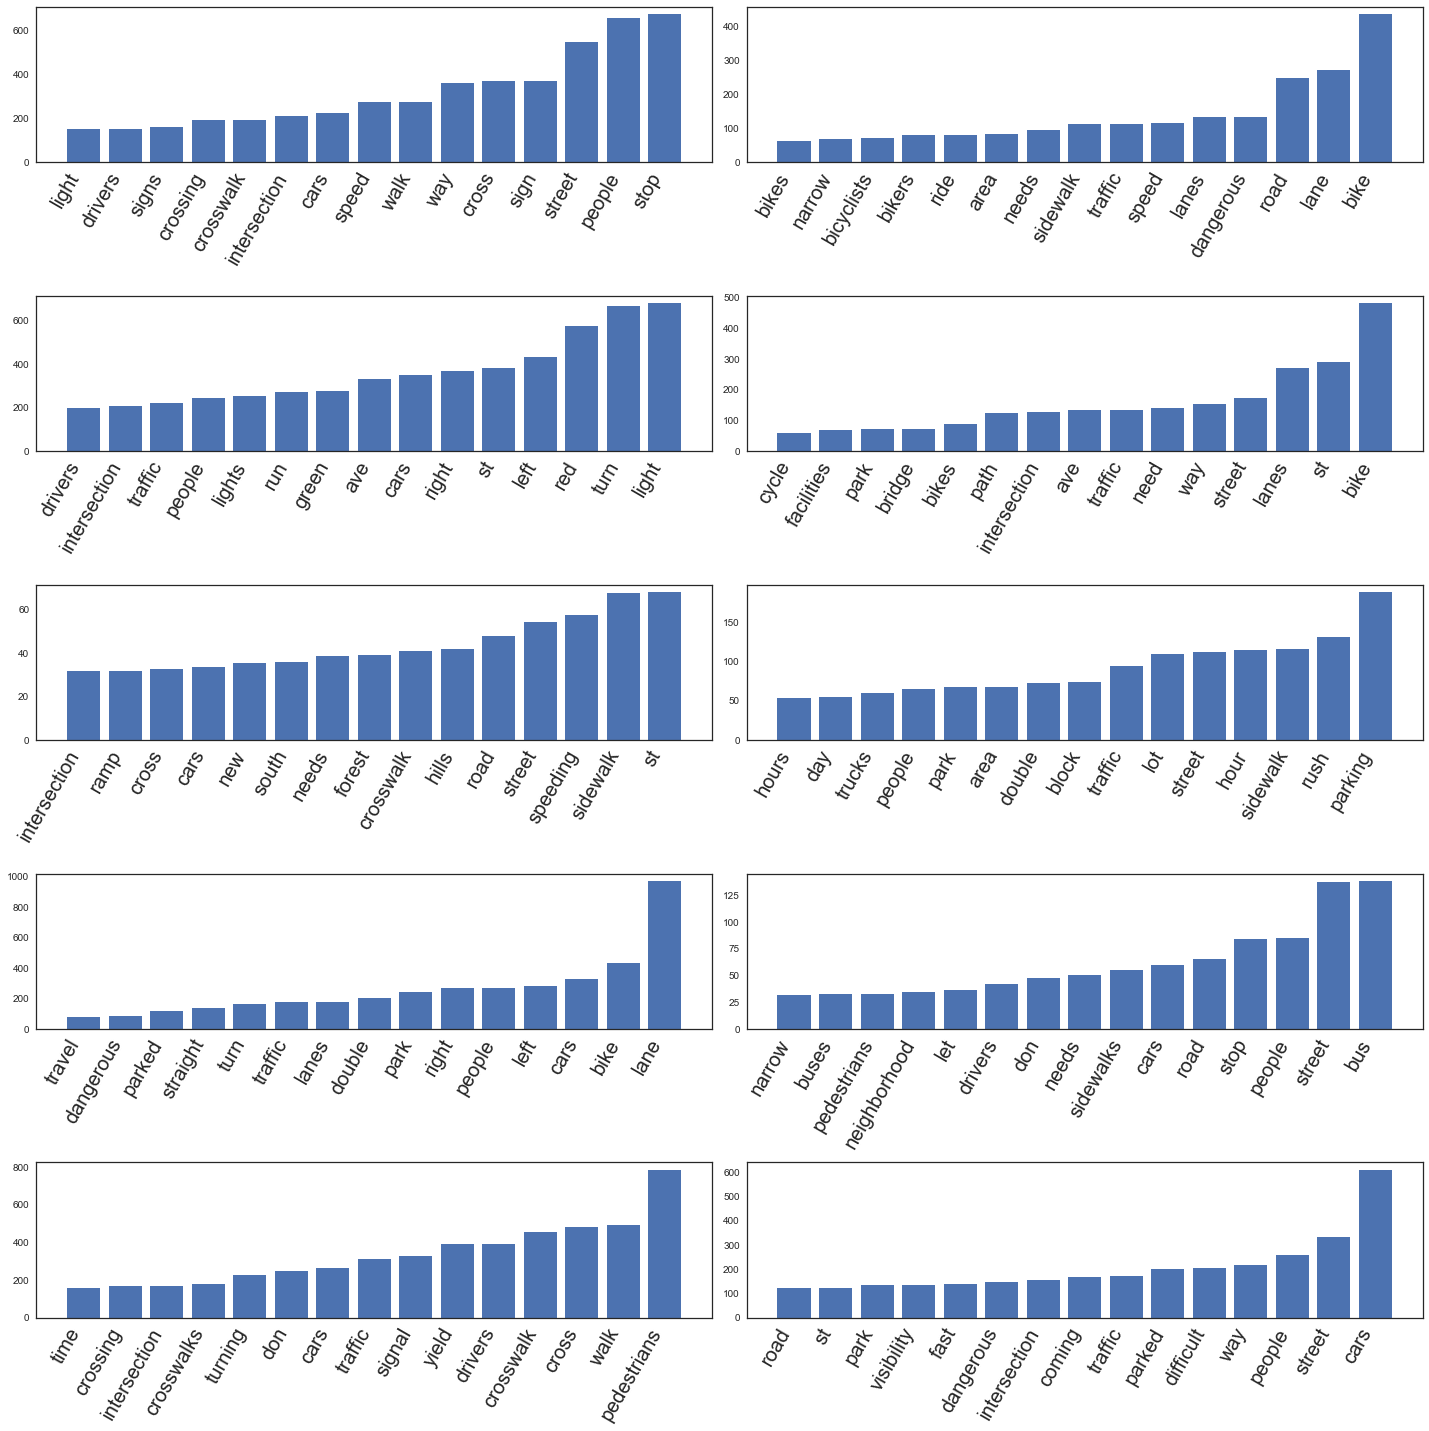

In [26]:
# Plot top words belonging to each topic
n_components = 10
fig, axes = plt.subplots(n_components // 2, 2, figsize=(20, 20))
for  ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
plt.tight_layout()

### b) NMF

In [27]:
# Add your code for task 5 here. You may use multiple cells. 

vect = CountVectorizer(ngram_range=(1,2), stop_words="english")
nmf_scale = NMF(n_components=10, tol=0.01, random_state=6)
scaler = MaxAbsScaler()
nmf_pipe = Pipeline([('vec',vect), ('Scaler',scaler), ('nmf',nmf_scale)])
X_nmf = nmf_pipe.fit_transform(X)

In [28]:
large_comp_inds = np.argsort(X_nmf.mean(axis=0))[-10:][::-1]
feature_names = np.array(nmf_pipe.named_steps['vec'].get_feature_names())

In [29]:
sorting = np.argsort(nmf_pipe.named_steps["nmf"].components_, axis=1)[:, ::-1]

In [30]:
# print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
turning       bike          don yield     stop          facilities    
right         lane          yield         stop sign     bike facilities
drivers turningbike lane     don           sign          bike          
turning left  lanes         pedestrians   people        stretch       
turning right right         yield pedestriansspeed         separated     
left          needs         people don    way stop      designed      
cars turning  road          drivers don   run stop      separated bike
turn          bike lanes    drivers       intersection  add           
cars          traffic       crosswalk     street        poorly        
people turningave           cars don      stop signs    standard      


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      

** ARI Score **

In [31]:
ari = adjusted_rand_score(y.values, np.argsort(X_nmf)[:,-1])
print(ari)

0.123312913206


** Visualizing NMF **

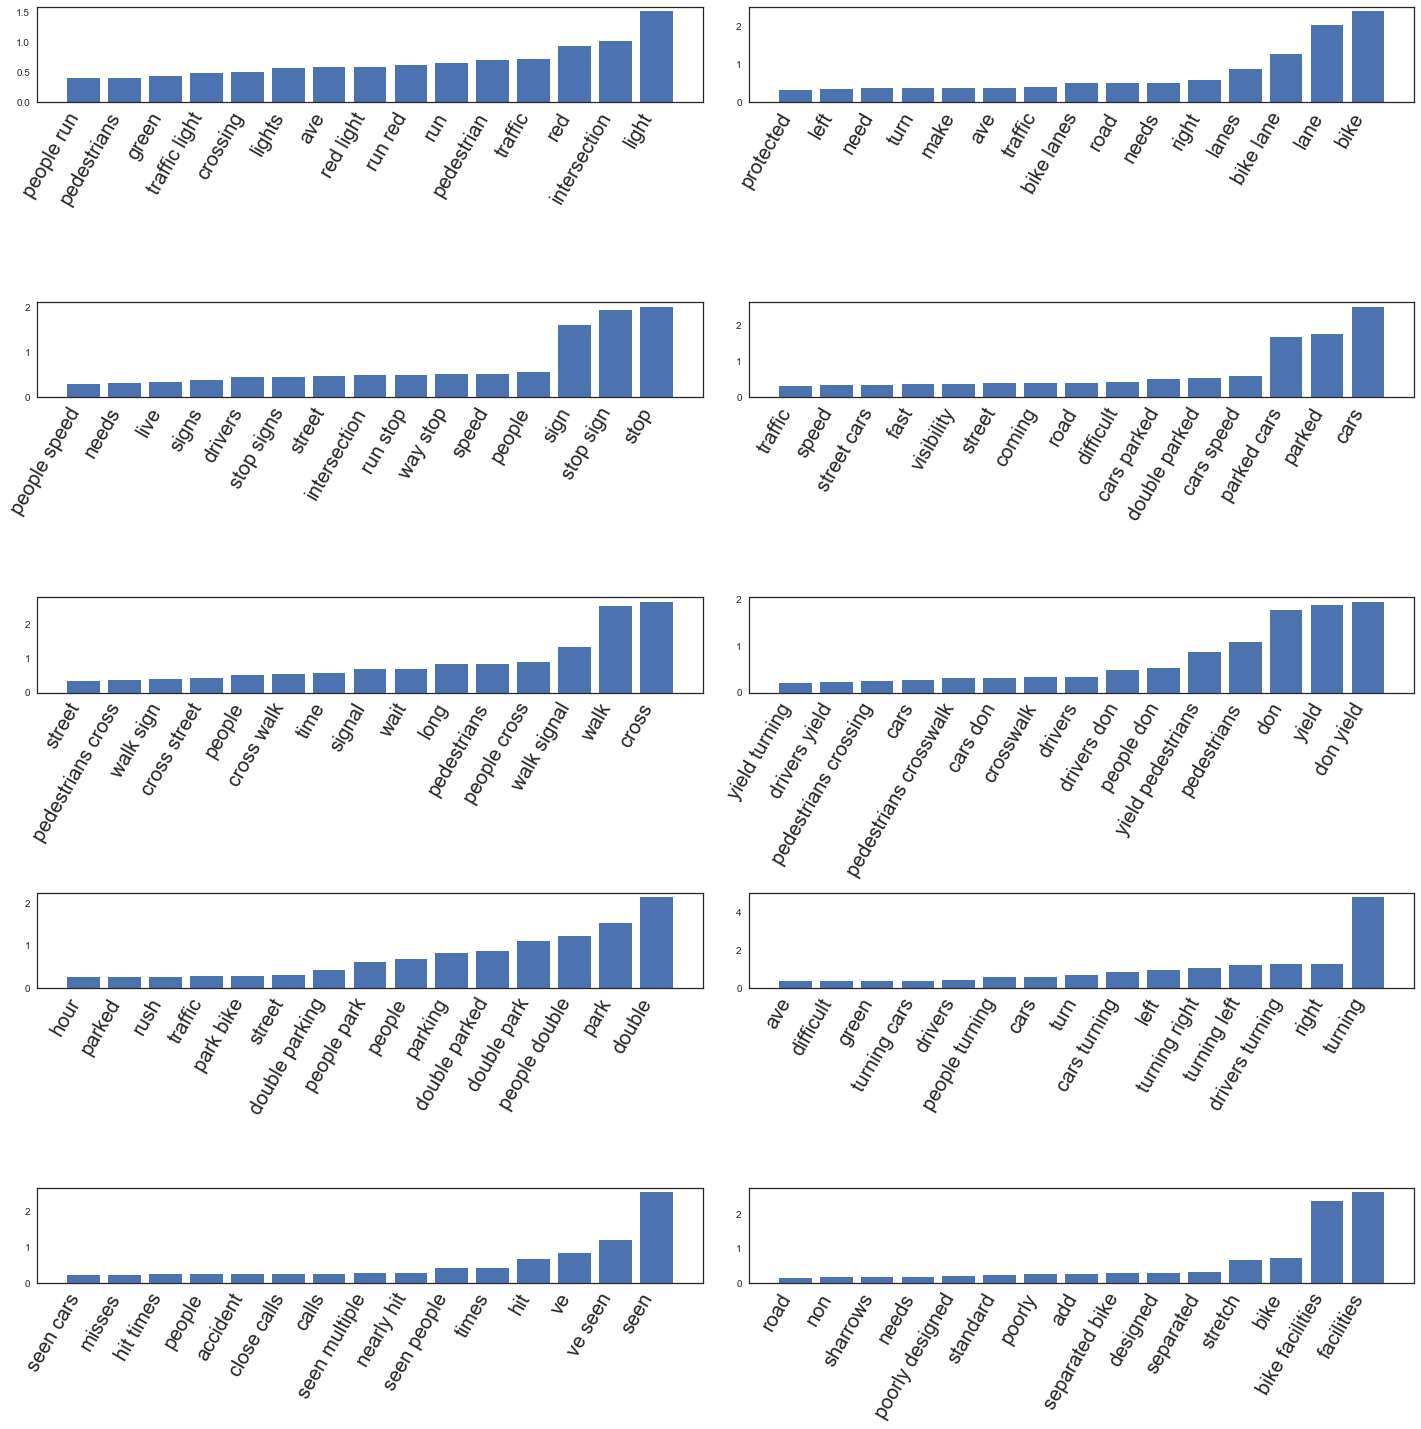

In [32]:
n_components = 10
fig, axes = plt.subplots(n_components // 2, 2, figsize=(20, 20))

for ax, coef in zip(axes.ravel(), nmf_pipe.named_steps['nmf'].components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

### 3) K - Means

In [40]:
vect = CountVectorizer(stop_words="english")

km = KMeans(n_clusters=14, random_state=0)
km_pipe = Pipeline([('vec',vect), ('kmeans', km)])
km_pipe.fit(X)

Pipeline(steps=[('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...s=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0))])

In [41]:
X_SVD = vect.fit_transform(X)

In [42]:
ari = adjusted_rand_score(y.values, km_pipe.named_steps['kmeans'].labels_)
print(ari)

0.0741550469795


In [45]:
sns.set_style("dark")

In [46]:
from sklearn.decomposition import TruncatedSVD
comp_pca = TruncatedSVD(n_components=2).fit_transform(X_SVD)

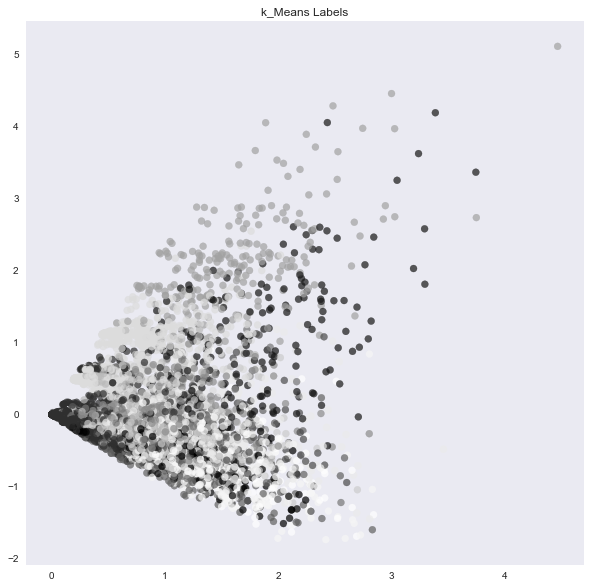

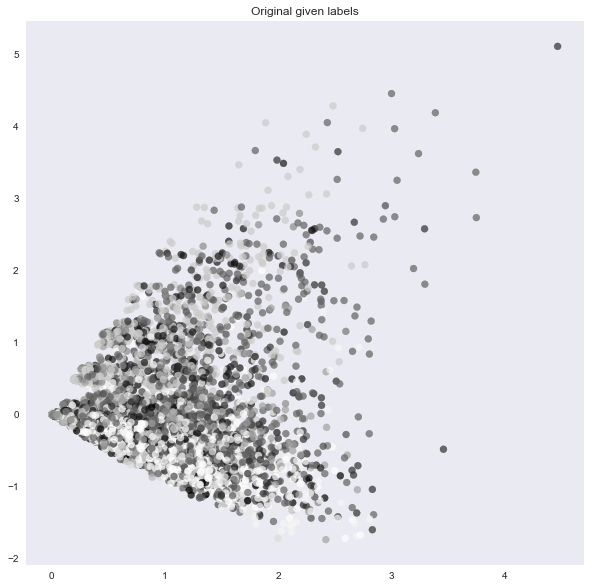

In [48]:
plt.figure(figsize=[10,10])
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=km.labels_, alpha=.7)
plt.title("k_Means Labels")
plt.show()
plt.figure(figsize=[10,10])
plt.scatter(comp_pca[:, 0], comp_pca[:, 1], c=y, alpha=.7)
plt.title("Original given labels")
plt.show()

** Comments: **
* ARI Score is the highest for NMF and is equal to 0.123
* Topics obtained from NMF and LDA do not seem to match well with the class labels as it is observed from the ARI score.

# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


### 1. Cluster Labels as final labels for classification

### a) Re-assignment of Labels using NMF

In [52]:
# Add your code for task 6 here. You may use multiple cells. 
# Pick the topic with the highest coefficient for each document
y_new = np.argsort(X_nmf)[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y_new, stratify=y_new, random_state=0)

In [53]:
%%time
pipeline = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__ngram_range": ((1, 1), ),  # unigrams or bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [10, 100]
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.7850707617239551
Best parameters {'clf__C': 10, 'vect__ngram_range': (1, 1)}
macro f1: 0.7960047415954393
CPU times: user 915 ms, sys: 83.9 ms, total: 999 ms
Wall time: 5.8 s


**Comments:**
* We obtain a F-1 macro score of **0.796** by training a Logistic Model on the re-assigned labels using NMF
* Unigram features give the best result in this case

### b) Re-assignment of labels using LDA

In [54]:
y_new = np.argsort(document_topics)[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y_new, stratify=y_new, random_state=0)

In [55]:
%%time
pipeline = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__ngram_range": ((1, 1), ),  # unigrams or bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [10, 100]
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.6319853160952367
Best parameters {'clf__C': 10, 'vect__ngram_range': (1, 1)}
macro f1: 0.6366708388250432
CPU times: user 1.06 s, sys: 106 ms, total: 1.16 s
Wall time: 6.2 s


**Comments:**
* We obtain a F-1 score of 0.64 by training a Logistic model on the re-assigned labels using LDA.

### c) Reassignment of labels using K-Means

In [56]:
y_new = km_pipe.named_steps['kmeans'].labels_
X_train, X_test, y_train, y_test = train_test_split(X, y_new, stratify=y_new, random_state=0)

In [57]:
%%time
pipeline = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__ngram_range": ((1, 2), ),  # unigrams or bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [10, 100]
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.8261754581798485
Best parameters {'clf__C': 10, 'vect__ngram_range': (1, 2)}
macro f1: 0.8372611331078633
CPU times: user 2.68 s, sys: 124 ms, total: 2.81 s
Wall time: 16.5 s


**Comments:**
* We obtain a F-1 score of 0.84 by training a Logistic model on the re-assigned labels using K-means.

### 2. Topic Modeling on "Other" Category and recalculating classification scores

We apply NMF on the subset of comments assigned to 'not listed here' class. We obtain the topic distribution for each of these comments and assign the topic of highest weight to the comment. We then combine the top words of these topics and find the **cosine similarity** with the important features of each of the other 13 classes. Based on the similarity measure we map the topic with the class label. All the comments belonging to the topic is mapped with the new class label.

In [85]:
X = data_df["COMMENTS"].copy()
y = data_df["REQUESTTYPE_CLASS"].copy()

In [86]:
X_others = X.loc[y == 9]

In [87]:
# Apply NMF 
vect = CountVectorizer(ngram_range=(1, 2), stop_words="english")
nmf_scale = NMF(n_components=5, tol=0.01, random_state=6)
scaler = MaxAbsScaler()
nmf_pipe = Pipeline([('vec', vect), ('Scaler', scaler), ('nmf', nmf_scale)])
X_nmf = nmf_pipe.fit_transform(X_others)

In [88]:
feature_names = np.array(nmf_pipe.named_steps['vec'].get_feature_names())
sorting = np.argsort(nmf_pipe.named_steps["nmf"].components_, axis=1)[:, ::-1]

In [89]:
topic_strings = []
for i in range(sorting.shape[0]):
    topic = ""
    curr_arr = sorting[i]
    for j in range(20):
        topic = topic + " " + feature_names[curr_arr[j]]
    topic_strings.append(topic)
    
len(topic_strings)

5

In [90]:
# print out the 10 topics:
mglearn.tools.print_topics(topics=range(5), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
park          pedestrian    lane          light         yield         
street        crossing      right         traffic       yield pedestrians
parking       pedestrian crossingleft          red           pedestrians   
cars          safer         turn          green light   cars          
direction     vehicles      left lane     green         don           
making        feel          lanes         walk          crosswalk     
people park   crossing lightcars          cars          don yield     
makes         attempt       straight      pedestrians   confusing     
wrong way     safer crossingmarkings      ave           cars don      
people        intersection pedestrianbetter        lights        crossing      
way street    pedestrian lightaccidents     intersection  stop          
way           feel safer    turn lane     cross         in

In [91]:
cluster_strings = []

for k, v in important_feature_names.items():
    curr_string = ""
    for string_vals in v:
        curr_string = curr_string + " " + string_vals
    cluster_strings.append(curr_string)

In [92]:
len(cluster_strings)

14

In [93]:
#cluster_strings

In [94]:
#topic_strings

In [95]:
topic_map = {}
for i, topic_string in enumerate(topic_strings):
    documents = [topic_string] + cluster_strings
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
    #print(tfidf_matrix.shape)
    #print(np.argsort(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)))
    topic_map[i] = np.argsort(cosine_similarity(tfidf_matrix[0:1], tfidf_matrix))[:, -2]

In [96]:
topic_map

{0: array([10]), 1: array([9]), 2: array([11]), 3: array([2]), 4: array([12])}

In [97]:
nmf_labels = np.argsort(X_nmf, axis = 1)[:, -1]

In [98]:
#nmf_labels

In [99]:
final_labels = []
for label in nmf_labels:
    for k, v in topic_map.items():
        if label == k:
            final_labels.append(v[0])

In [100]:
y[X_others.index] = final_labels

In [101]:
#np.sum(y == 9)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 2)

In [103]:
%%time
pipeline = Pipeline([
    ('vect', CountVectorizer()), 
    #('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    "vect__ngram_range": ((1, 2), ),  # unigrams or bigrams or trigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
    "clf__C": [1, 10]
}

prediction, grid = doGridSearch(pipeline, parameters, X_train, y_train, X_test, y_test)

Best cross validation score 0.511623200042874
Best parameters {'clf__C': 1, 'vect__ngram_range': (1, 2)}
macro f1: 0.5404719549813498
CPU times: user 4.55 s, sys: 677 ms, total: 5.23 s
Wall time: 25.3 s


In [104]:
if f1_score(y_test, prediction, average='macro') > 0.53:
    #print("True")
    assert True

True


# Extra Credit [Up to +20 points]

Use a word embedding representation like word2vec for step 3 and or step 6. 

In [83]:
#Add your code for extra credit here. You may use multiple cells. 

# from gensim import models
# w = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [84]:
# new_df = data_df[data_df["COMMENTS"].apply(lambda x: len(re.findall(r'\w+', x) ) > 1)]
# X = new_df.COMMENTS
# y = new_df.REQUESTTYPE_CLASS
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
# vect_w2v = CountVectorizer(vocabulary=w.index2word)
# vect_w2v.fit(X_train)
# docs = vect_w2v.inverse_transform(vect_w2v.transform(X_train))
# #docs[0]
# X_train = np.vstack([np.mean(w[doc], axis=0) for doc in docs])
# docs_val = vect_w2v.inverse_transform(vect_w2v.transform(X_test))
# X_test = np.vstack([np.mean(w[doc], axis=0) for doc in docs_val])
# lr_w2v = LogisticRegression(C=100).fit(X_train, y_train)
# prediction = lr_w2v.predict(X_test)
# f1_score(y_test, prediction, average='macro')

0.50795399943932995

** Comment ** : We applied word2vec for the task3 scenario and there was no significant improvement in the F1-score. The main reason can be the small size of our corpus and the available corpus being trained on dataset of a different domain.